### Setup

In [2]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

## Overview of the data

Let's start by getting familiar with our data. Remember that we can query the database to get a list of all tables and views in our database:

In [3]:
%%sql
SELECT 
    name,
    type
FROM sqlite_master
WHERE type IN ('table', 'view')

 * sqlite:///chinook.db
Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


### Selecting albums to purchase

The Chinook record store has just signed a deal with a new record label, and you've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:


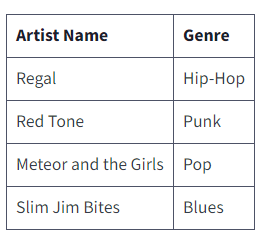

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

You'll need to write a query to find out which genres sell the most tracks in the USA, write up a summary of your findings, and make a recommendation for the three artists whose albums we should purchase for the store.


1- *Write a query that returns each genre, with the number of tracks sold in the USA:*

    - *in absolute numbers*
    - *in percentages.*
    
2. *Write a paragraph that interprets the data and makes a recommendation for the three artists whose albums we should purchase for the store, based on sales of tracks from their genres.*

In [14]:
%%sql

SELECT SUM(quantity)
FROM invoice_line

 * sqlite:///chinook.db
Done.


SUM(quantity)
4757


In [ ]:
SELECT g.name genre,
       SUM(il.quantity),
       CAST( SUM(il.quantity) AS FLOAT ) / (SELECT SUM(quantity) FROM invoice_line WHERE bi)
    FROM invoice_line il INNER JOIN genres g ON il.track_id = g.track_id
        INNER JOIN invoice i ON il.invoice_id = i.invoice_id
    WHERE i.billing_country = 'USA'
    GROUP BY g.name

In [24]:
%%sql

-- Table genre of each track_id
WITH genres AS (
        SELECT t.track_id, 
               g.name
        FROM track t INNER JOIN genre g ON t.genre_id = g.genre_id),

     sales_us AS(
         SELECT  SUM(il.quantity) total_us
             FROM invoice_line il INNER JOIN invoice i ON il.invoice_id = i.invoice_id
             WHERE i.billing_country = 'USA')

SELECT g.name genre,
       SUM(il.quantity) total_sales,
       ROUND( CAST( SUM(il.quantity) AS FLOAT ) / (SELECT total_us FROM sales_us) * 100 , 2) || ' %' sales_percentage
        
    FROM invoice_line il INNER JOIN genres g ON il.track_id = g.track_id
        INNER JOIN invoice i ON il.invoice_id = i.invoice_id
    WHERE i.billing_country = 'USA'
    GROUP BY g.name
    ORDER BY total_sales DESC

 * sqlite:///chinook.db
Done.


genre,total_sales,sales_percentage
Rock,561,53.38 %
Alternative & Punk,130,12.37 %
Metal,124,11.8 %
R&B/Soul,53,5.04 %
Blues,36,3.43 %
Alternative,35,3.33 %
Pop,22,2.09 %
Latin,22,2.09 %
Hip Hop/Rap,20,1.9 %
Jazz,14,1.33 %


**Recommendation**

Based on the data above I recommend to buy the album from Red Tone, Meteor and the Girls and Slim Jim Bites. The hip-hop genre is the least bought from the four options, the difference is small but that can make a difference.

### Analyzing employee sales performance.

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. You have been asked to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

You might like to consider whether any extra columns from the employee table explain any variance you see, or whether the variance might instead be indicative of employee performance.

*1) Write a query that finds the totall dollar amount of sales assigned to each sales support agent within the company. Add any extra attributes for that employee that you find are relevant to the analysis.*

*2) Write a short statement describing your results, and providing a possible interpretation.*

In [45]:
%%sql

WITH ss_agents AS ( 
        SELECT employee_id,
               first_name || ' ' || last_name name,
               2021 - birthdate age,
               2021 - hire_date antiquity, 
               country
            FROM employee
            WHERE title = 'Sales Support Agent' ),
   
    customer_sales AS ( 
        SELECT c.support_rep_id,
               COUNT(c.customer_id) number_customers,
               SUM(CAST(i.total AS FLOAT)) total
        FROM customer c INNER JOIN invoice i ON c.customer_id = i.customer_id
        GROUP BY support_rep_id )

SELECT ss.name, 
       ss.age,
       ss.antiquity,
       ss.country,
       cs.number_customers,
       cs.total
    FROM ss_agents ss 
        INNER JOIN customer_sales cs ON ss.employee_id = cs.support_rep_id
    ORDER BY cs.total DESC

 * sqlite:///chinook.db
Done.


name,age,antiquity,country,number_customers,total
Jane Peacock,48,4,Canada,212,1731.510000000004
Margaret Park,74,4,Canada,214,1584.0000000000032
Steve Johnson,56,4,Canada,188,1393.9200000000028


Jane Peacock had a better performance than his collegues, she had almost the same customers assigned than Margaret but has more tracks sold.

### Analyzing sales by country

Your next task is to analyze the sales data for customers from each different country. You have been given guidance to use the **country value from the customers table**, and **ignore the country from the billing address** in the invoice table.

In particular, you have been directed to calculate data, for each country, on the:

- total number of customers
- total value of sales
- average value of sales per customer
- average order value

Because there are a number of countries with only one customer, you should group these customers as "Other" in your analysis. You can use the following 'trick' to force the ordering of "Other" to last in your analysis.


**Others** row.

If there is a particular value that you would like to force to the top or bottom of results, you can put what would normally be your most outer query in a subquery with a case statement that adds a numeric column, and then in the outer query sort by that column. Here's an example - let's start by creating a view so we're working with a manageable number of rows:

In [46]:
%%sql

CREATE VIEW top_5_names AS
     SELECT
         first_name,
         count(customer_id) count
     FROM customer
     GROUP by 1
     ORDER by 2 DESC
     LIMIT 5;


SELECT * FROM top_5_names;

 * sqlite:///chinook.db
Done.
Done.


first_name,count
Mark,2
Frank,2
Wyatt,1
Victor,1
Tim,1


Next, inside a subquery, we'll select all values from our view and add a sorting column using a case statement, before sorting using that new column in the outer query.

In [47]:
%%sql

SELECT
    first_name,
    count
FROM
    (
    SELECT
        t5.*,
        CASE
            WHEN t5.first_name = "Mark" THEN 1
            ELSE 0
        END AS sort
    FROM top_5_names t5
   )
ORDER BY sort ASC

 * sqlite:///chinook.db
Done.


first_name,count
Frank,2
Wyatt,1
Victor,1
Tim,1
Mark,2


You should be able to adapt this technique into your query to force 'Other' to the bottom of your results. When working through this exercise, you will need multiple subqueries and joins. Imagine you work on a team of data analysts, and write your query so that it will be able to be easily read and understood by your colleagues.

### Exercise

Write a query that collates data on purchases from different countries.
- Where a country has only one customer, collect them into an "Other" group.
- The results should be sorted by the total sales from highest to lowest, with the "Other" group at the very bottom.
- For each country, include:
    - total number of customers
    - total value of sales
    - average value of sales per customer
    - average order value

In [41]:
%%%sql

-- Reusing table with general purchases from customers
-- Table with total amount spent by customer
WITH spent_customer AS 
   (
    SELECT c.customer_id,
           c.country
     FROM customer c INNER JOIN invoice i ON c.customer_id = i.customer_id
     GROUP BY c.customer_id),

-- Finding Others...
others AS(
      SELECT country
      FROM spent_customer
      GROUP BY country
      HAVING COUNT(customer_id) = 1),

-- Getting the useful information per customer but considering the label "Other"
-- as a country, where needed
customer_countries AS
  (SELECT c.customer_id,
       CASE 
        WHEN c.country IN (SELECT * FROM others) THEN 'Other'
        ELSE c.country
       END AS country,
       COUNT(i.invoice_id) number_of_orders,
       SUM(i.total) total_spent
    FROM customer c INNER JOIN invoice i ON c.customer_id = i.customer_id
    GROUP BY c.customer_id),

-- The actual useful information
country_information AS
  (
    SELECT country,
           COUNT(customer_id) Number_of_customers,
           SUM(total_spent) Total_sales,
           CAST(SUM(total_spent) AS float) / COUNT(customer_id) avg_sales_per_customer,
           CAST(SUM(total_spent) AS float) / number_of_orders avg_order_value
    
    FROM customer_countries 
    GROUP BY country
    ORDER BY Total_sales DESC )

-- The final 'trick'
SELECT country,
       Number_of_customers,
       Total_sales,
       avg_sales_per_customer,
       avg_order_value
FROM (SELECT c_inf.*,
             CASE
                WHEN c_inf.country = 'Other' THEN 1
                ELSE 0
             END AS sort
      FROM country_information c_inf)
ORDER BY sort ASC

Done.


country,Number_of_customers,Total_sales,avg_sales_per_customer,avg_order_value
USA,13,1040.49,80.03769230769231,104.049
Canada,8,535.59,66.94875,44.6325
Brazil,5,427.67999999999995,85.53599999999999,28.511999999999997
France,5,389.07,77.814,32.4225
Germany,4,334.62,83.655,37.18
Czech Republic,2,273.24,136.62,22.77
United Kingdom,3,245.51999999999998,81.83999999999999,27.279999999999998
Portugal,2,185.13,92.565,11.570625
India,2,183.14999999999998,91.57499999999999,22.893749999999997
Other,15,1094.94,72.99600000000001,84.22615384615385


**Hay que analizar la respuesta "oficial"**

In [42]:
%%%sql

-- Reusing table with general purchases from customers
-- Table with total amount spent by customer
WITH spent_customer AS 
   (
    SELECT c.customer_id,
           c.country
     FROM customer c INNER JOIN invoice i ON c.customer_id = i.customer_id
     GROUP BY c.customer_id),

-- Finding Others...
others AS(
      SELECT country
      FROM spent_customer
      GROUP BY country
      HAVING COUNT(customer_id) = 1),

-- Getting the useful information per customer but considering the label "Other"
-- as a country, where needed
customer_countries AS
  (SELECT c.customer_id,
       CASE 
        WHEN c.country IN (SELECT * FROM others) THEN 'Other'
        ELSE c.country
       END AS country,
       COUNT(i.invoice_id) number_of_orders,
       SUM(i.total) total_spent
    FROM customer c INNER JOIN invoice i ON c.customer_id = i.customer_id
    GROUP BY c.customer_id)

-- The actual useful information
SELECT country,
       COUNT(customer_id) Number_of_customers,
       SUM(total_spent) Total_sales,
       CAST(SUM(total_spent) AS float) / COUNT(customer_id) avg_sales_per_customer,
       CAST(SUM(total_spent) AS float) / number_of_orders avg_order_value
        
-- Usin a trick for the "Other" class
FROM ( SELECT c_c.*,
          CASE WHEN c_c.country = 'Other' THEN 1
           ELSE 0
          END AS sort
      FROM customer_countries c_c)
GROUP BY country
ORDER BY sort ASC, Total_sales DESC


Done.


country,Number_of_customers,Total_sales,avg_sales_per_customer,avg_order_value
USA,13,1040.49,80.03769230769231,104.049
Canada,8,535.59,66.94875,44.6325
Brazil,5,427.67999999999995,85.53599999999999,28.511999999999997
France,5,389.07,77.814,32.4225
Germany,4,334.62,83.655,37.18
Czech Republic,2,273.24,136.62,22.77
United Kingdom,3,245.51999999999998,81.83999999999999,27.279999999999998
Portugal,2,185.13,92.565,11.570625
India,2,183.14999999999998,91.57499999999999,22.893749999999997
Other,15,1094.94,72.99600000000001,84.22615384615385


### Final boss

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

It is very common when you are performing an analysis to have 'edge cases' which prevent you from getting a 100% accurate answer to your question. In this instance, we have two edge cases to consider:

- Albums that have only one or two tracks are likely to be purchased by customers as part of a collection of individual tracks.
- Customers may decide to manually select every track from an album, and then add a few individual tracks from other albums to their purchase.

In the first case, since our analysis is concerned with maximizing revenue we can safely ignore albums consisting of only a few tracks. The company has previously done analysis to confirm that **the second case does not happen often, so we can ignore this case also**.


In order to answer the question, we're going to have to **identify whether each invoice has all the tracks from an album**. We can do this by getting the list of tracks from an invoice and comparing it to the list of tracks from an album. We can find the album to compare the purchase to by looking up the album that one of the purchased tracks belongs to. It doesn't matter which track we pick, since if it's an album purchase, that album will be the same for all tracks.

In [43]:
%%%sql

-- Table with the invoice id and one song (the first one, but whatever is fine)
SELECT invoice_id,
       MIN(track_id) first_track_id
    FROM invoice_line il
    GROUP BY invoice_id

Done.


invoice_id,first_track_id
1,1158
2,201
3,2516
4,748
5,1986
6,30
7,42
8,81
9,196
10,2663


We can use the previous table as a subquery... Based on those invoice_ids and those track_ids we can find the album_id and all the rest of tracks_ids of the album and comparing it with all the track_ids from the invoice.

In [44]:
%%%sql
-- Table with the invoice id and one song (the first one, but whatever is fine)
WITH invoice_first_track AS
    (SELECT 
         invoice_id,
         MIN(track_id) first_track_id
     FROM invoice_line il
     GROUP BY invoice_id)
    
-- Select all tracks ids
SELECT t.track_id 
FROM track t INNER JOIN (SELECT t2.album_id 
                         FROM track t2 INNER JOIN invoice_first_track ifs ON
                                   t2.track_id = ifs.first_track_id) subq
    ON t.album_id = subq.album_id

Done.


track_id
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167


In [45]:
%%sql

-- Table with the invoice id and one song (the first one, but whatever is fine)
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )
    
-- Main query

SELECT album_purchase,  --Binary variable, yes or no... We are going to group by this column
       COUNT(invoice_id) number_of_invoices,      -- Count number of invoice for yes and no
       CAST(COUNT(invoice_id) AS FLOAT) / (      -- Percentage... total is all invoices 
                                            SELECT COUNT(*) FROM invoice
                                          ) percent

        
FROM ( 
      SELECT ifs.*,   -- All columns from subquery invoice_first_track
      CASE            -- This additional column is for album_purchased
        WHEN
            (
             SELECT t.track_id FROM track t  -- Select all tracks ids
                                             -- ... but only for the albums in first_track_id 
                                             -- (the ones purchased)
             WHERE t.album_id = (SELECT t2.album_id FROM track t2
                                  WHERE t2.track_id = ifs.first_track_id)
            
            EXCEPT  -- Intersecting with
                
            SELECT il2.track_id FROM invoice_line il2   -- Selecting all tracks in invoice
            WHERE il2.invoice_id = ifs.invoice_id
            ) IS NULL
         AND   -- Same as above but in reverse order EXCEPT is non commutative
            (
            SELECT il2.track_id FROM invoice_line il2  -- All songs in invoice
            WHERE il2.invoice_id = ifs.invoice_id
                
            EXCEPT
                
            SELECT t.track_id FROM track t     -- All tracks from the same album as first_track_id
            WHERE t.album_id = (
                                SELECT t2.album_id FROM track t2
                                WHERE t2.track_id = ifs.first_track_id
                                )
            
            ) IS NULL   -- If thos intersections are null then it is a full album buying operation
        THEN 'yes'
        ELSE 'no'
     END AS "album_purchase"
    
    FROM invoice_first_track ifs
)

GROUP BY album_purchase

Done.


album_purchase,number_of_invoices,percent
no,500,0.8143322475570033
yes,114,0.18566775244299674


In [47]:
%%sql

-- Table with the invoice id and one song (the first one, but whatever is fine)
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )
    
-- Main query

SELECT album_purchase,  --Binary variable, yes or no... We are going to group by this column
       COUNT(invoice_id) number_of_invoices,      -- Count number of invoice for yes and no
       CAST(COUNT(invoice_id) AS FLOAT) / (      -- Percentage... total is all invoices 
                                            SELECT COUNT(*) FROM invoice
                                          ) percent

        
FROM ( 
      SELECT ifs.*,   -- All columns from subquery invoice_first_track
      CASE            -- This additional column is for album_purchased
        WHEN
            (
            -- Select track_ids from the same album as first_track_id
             SELECT t.track_id 
                FROM track t 
                WHERE t.album_id = (SELECT t2.album_id
                                    FROM track t2
                                    WHERE t2.track_id = ifs.first_track_id)
                                       
                
            EXCEPT  -- Intersecting with
            
            -- Selecting all tracks in invoice
            SELECT il2.track_id FROM invoice_line il2   
            WHERE il2.invoice_id = ifs.invoice_id
                
            ) IS NULL    -- There are no songs
    
         AND   -- Same as above but in reverse order EXCEPT is non commutative
    
            (
            SELECT il2.track_id FROM invoice_line il2  -- All songs in invoice
            WHERE il2.invoice_id = ifs.invoice_id
                
            EXCEPT
                
            SELECT t.track_id FROM track t     -- All tracks from the same album as first_track_id
            WHERE t.album_id = (
                                SELECT t2.album_id FROM track t2
                                WHERE t2.track_id = ifs.first_track_id
                                )
            
            ) IS NULL   -- If thos intersections are null then it is a full album buying operation
        THEN 'yes'
        ELSE 'no'
     END AS "album_purchase"
    
    FROM invoice_first_track ifs
)

GROUP BY album_purchase

Done.


album_purchase,number_of_invoices,percent
no,500,0.8143322475570033
yes,114,0.18566775244299674
